In [1]:
import os # operating system
import pandas as pd
import shutil # shell utilities
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import layers
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

notes for me; there are two ways that we can use pretrained models to make things easier

* feature extraction, which freezes the pretrained layers and adds a new classification layer at the end
    this method is fast and simple, and works well with small-medium datasets

* fine-tuning, which unfreezes some of the top layers so they can update their understanding of the data
    this method takes takes more time and is more advanced, but usually leads to better performance

In [2]:
csvPath = 'harData/Training_set.csv'
df = pd.read_csv(csvPath)

print("Preview of the dataset:")
print(df.head())

Preview of the dataset:
      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop


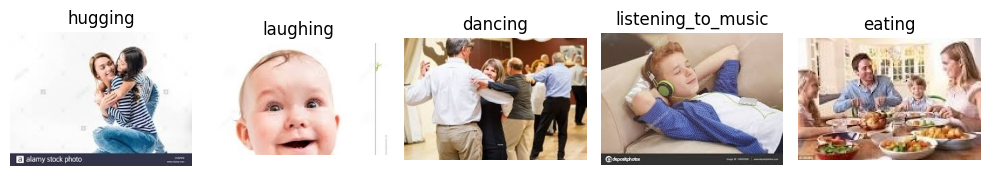

In [3]:
imageFolder = 'harData/train_sorted'
plt.figure(figsize=(10, 6))
randomSample = df.sample(n=5)

for i, (_, row) in enumerate(randomSample.iterrows()): # randomly displays 5 photos in the dataset
    imgPath = os.path.join(imageFolder, row['label'], row['filename'])
    label = row['label']
    image = Image.open(imgPath) # uses pil to open the image

    ax = plt.subplot(1, 5, i + 1) # subplots each image
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

trainDS = tf.keras.utils.image_dataset_from_directory(
    imageFolder,
    image_size =(224, 224), # image resizing to 224x224
    batch_size = 32, # processes 32 images per batch
    label_mode = 'categorical', # enables one-hot encoding / binary vectors
    shuffle = True
)

# note; image_size, batch_size, and label_mode are NOT user-made variables

Found 12600 files belonging to 15 classes.


note to self; image_dataset_from_directory automatically allows tf to read, resize, encode, and batch the images for training

unfortunately, normalization still has to be applied manually as tf loads images ranging 0-255 and not 0-1 :sweat:

In [5]:
classNames = trainDS.class_names # double check the labels
print("Class Labels:")
for i, className in enumerate(classNames, 1):
    print(f"{i}. {className}")

Class Labels:
1. calling
2. clapping
3. cycling
4. dancing
5. drinking
6. eating
7. fighting
8. hugging
9. laughing
10. listening_to_music
11. running
12. sitting
13. sleeping
14. texting
15. using_laptop


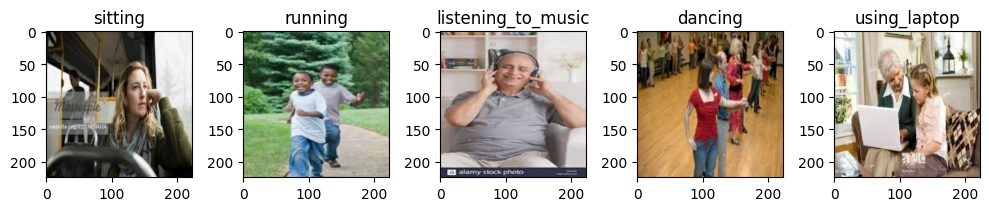

In [6]:
# note; this double checks to make sure tf loaded the images right

plt.figure(figsize=(10,6))
for images, labels in trainDS.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classNames[labels[i].numpy().argmax()]) 
        plt.axis = "off"
plt.tight_layout()
plt.show()

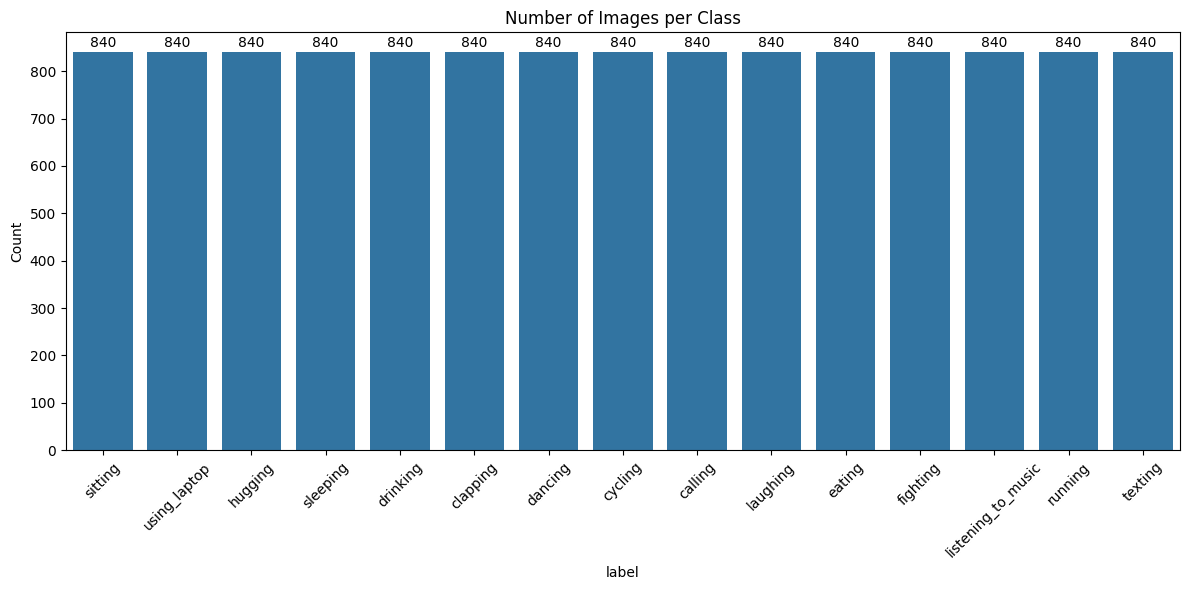

In [7]:
classCounts = df['label'].value_counts() 

plt.figure(figsize=(12,6))
ax = sns.barplot(x = classCounts.index, y = classCounts.values)
plt.title("Number of Images per Class")
plt.ylabel("Count")
plt.xticks(rotation = 45)

for bar in ax.patches: # graph the sample sizes
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 5,
        int(height),
        ha = 'center', va='bottom'
    )

plt.tight_layout()
plt.show()

# no data augmentation needed; each class has 840 samples

In [8]:
fig = px.pie(names = classCounts.index, values = classCounts, title = "Distribution of Human Activity Classes")
fig.show() # creates pie chart of the class labels

# note; to run fig.show(), you need to run pip install --upgrade nbformat

In [9]:
# loading the pretrained model so that i can start transfer learning

baseModel = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet'
)

baseModel.trainable = False

model = Sequential([
    baseModel,
    GlobalAveragePooling2D(),
    Dropout(0.3), # randomly turns off 30% of neurons
    Dense(128, activation = 'relu'), # patterns, non-linearity
    Dense(15, activation = 'softmax') # outputs probabilities 
])

# note; input_shape and include_top are NOT user-made variables

note to self; MobileNetV2 is a lightweight cnn with pretrained knowledge that allows you to utilize transfer learning
* include_top = false removes the original classification layers
* weight = 'imagenet' loads pre-trained weights so that you don't have to start from scratch
* baseModel.trainable = false freezes the base layers so that they aren't modified during training

when transfer learning starts, we put in new classification layers to categorize the extracted features
* GlobalAveragePooling2D() reduces the data size while keeping the key features
* MobileNetV2 is the base model, while pooling, dropout, and the dense layers are classification layers

In [10]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

model.summary()
print("Model compiled and ready to train!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Model compiled and ready to train!


note to self; model.summary() gives you a breakdown of the model structure in table format
* layer (type) is self explanatory
* output shape tells you the data's shape after it passes through each layer
* param # indicates how many weights are in each layer 

In [11]:
valDS = trainDS.take(20)
trainDS = trainDS.skip(20)

history = model.fit(
    trainDS,
    validation_data = valDS,
    epochs = 5
)

# note; validation_data is NOT a user-made variable

Epoch 1/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 180s 468ms/step - accuracy: 0.1615 - loss: 2.6090 - val_accuracy: 0.2500 - val_loss: 2.2116
Epoch 2/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 159s 424ms/step - accuracy: 0.2811 - loss: 2.2080 - val_accuracy: 0.2859 - val_loss: 2.0968
Epoch 3/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 1026s 3s/step - accuracy: 0.3123 - loss: 2.1024 - val_accuracy: 0.2891 - val_loss: 2.0763
Epoch 4/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 1022s 3s/step - accuracy: 0.3278 - loss: 2.0596 - val_accuracy: 0.3187 - val_loss: 2.0184
Epoch 5/5
374/374 ━━━━━━━━━━━━━━━━━━━━ 997s 3s/step - accuracy: 0.3417 - loss: 2.0190 - val_accuracy: 0.3313 - val_loss: 2.0187


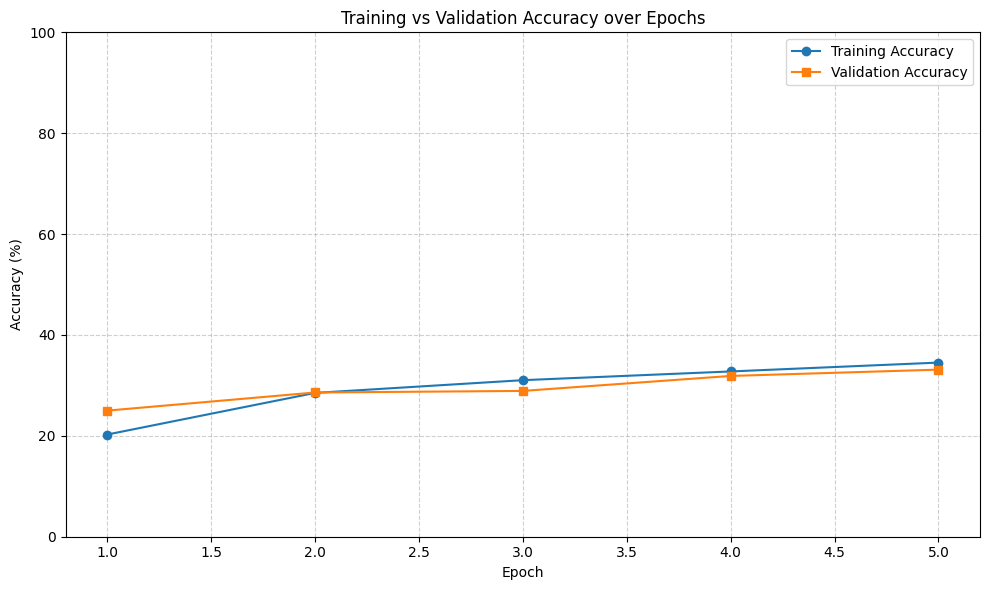

In [12]:
# graph for accuracy

epochs = range(1, len(history.history['accuracy']) + 1)
trainAcc = [ a * 100 for a in history.history['accuracy']]
valAcc = [ a * 100 for a in history.history['val_accuracy']]

plt.figure(figsize = (10, 6))
plt.plot(epochs, trainAcc, label = "Training Accuracy", marker = 'o')
plt.plot(epochs, valAcc, label = "Validation Accuracy", marker = 's')
plt.title("Training vs Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(True, linestyle = '--', alpha = 0.6)
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


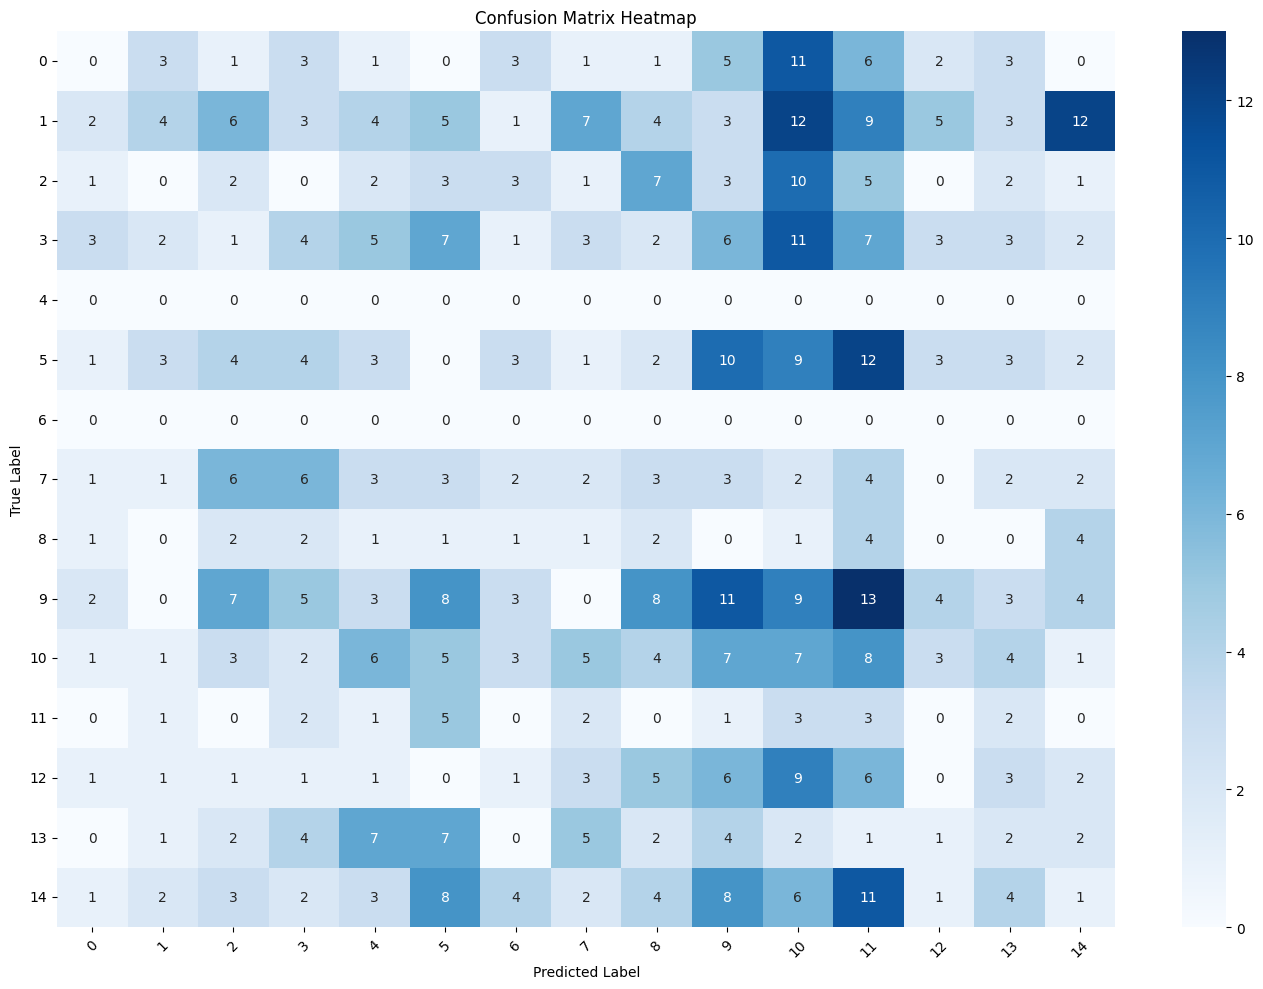

In [13]:
# adding a confusion matrix to see how the model did

yTrue = []
yPred = []

for images, label in valDS:
    preds = model.predict(images)
    yTrue.extend(tf.argmax(labels, axis = 1).numpy())
    yPred.extend(tf.argmax(preds, axis = 1).numpy())

cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize = (14, 10))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
xTickLabels = classNames,
yTickLabels = classNames
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [14]:
# bias checking w a classifcation report
print(classification_report(yTrue, yPred, target_names = classNames))
# note; target_names is NOT a user-made variable

                    precision    recall  f1-score   support

           calling       0.00      0.00      0.00        40
          clapping       0.21      0.05      0.08        80
           cycling       0.05      0.05      0.05        40
           dancing       0.11      0.07      0.08        60
          drinking       0.00      0.00      0.00         0
            eating       0.00      0.00      0.00        60
          fighting       0.00      0.00      0.00         0
           hugging       0.06      0.05      0.05        40
          laughing       0.05      0.10      0.06        20
listening_to_music       0.16      0.14      0.15        80
           running       0.08      0.12      0.09        60
           sitting       0.03      0.15      0.06        20
          sleeping       0.00      0.00      0.00        40
           texting       0.06      0.05      0.05        40
      using_laptop       0.03      0.02      0.02        60

          accuracy                    

c:\Users\elian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\elian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\elian\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

